In [1]:
# Importing libraries

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols

import math

pd.set_option('display.max_rows', 25)  # Display all rows
pd.set_option('display.max_columns', 50)  # Display all columns
pd.set_option('display.width', 100)  # Set the display width to fit the entire DataFrame

In [2]:
#importing file from csv
mca = pd.read_csv(r"C:\Users\ssara\OneDrive\Ambiente de Trabalho\Class 1\4. Labs\10. OCT lab-customer-analysis-final-round\files_for_lab\csv_files\marketing_customer_analysis.csv")
mca

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,Urban,Married,73,18,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,Suburban,Single,85,9,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,Suburban,Married,96,34,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large


In [3]:
def clean_process(df, max_correlation, ycolumn):
    # Lowercasing column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Dealing with NaNs
    df = df.dropna(axis=1, thresh=len(df) * 0.5)  # Drop columns with more than 50% NaN
    df = df.drop(columns=['unnamed: 0'], errors='ignore')
    df = df.dropna().reset_index(drop=True)
    
    # Splitting Numerical and Categorical data
    numerical = mca._get_numeric_data()
    categorical = mca.drop(numerical.columns,axis=1)
    numerical = numerical.drop(['number_of_open_complaints','number_of_policies'],axis=1)
    categorical = categorical.drop(['customer','effective_to_date'],axis=1)
    
    xcols, ycols, correlation = [], [], []
    for xcol in numerical.columns:
        for ycol in numerical.columns:
            if xcol != ycol:
                r = numerical[xcol].corr(numerical[ycol])
                correlation.append(r)
                xcols.append(xcol)
                ycols.append(ycol)
                
    dropped_cols = set()
    counter = 0
    for i in range(len(correlation)):
        if correlation[i] > max_correlation:
            xcol, ycol = xcols[i], ycols[i]
            if xcol not in dropped_cols and ycol not in dropped_cols:
                if df[xcol].std() > df[ycol].std():
                    df = df.drop(columns=[ycol], axis=1)
                    dropped_cols.add(ycol)
                else:
                    df = df.drop(columns=[xcol], axis=1)
                    dropped_cols.add(xcol)
            counter += 1

    if counter == 0:
        print('No correlation higher than', max_correlation, 'was found.')
    else:
        print(counter, 'correlations higher than 0.9 were found.', len(dropped_cols), 'columns were dropped.')

    print('Maximum correlation is', max(correlation))

    sns.heatmap(df.corr(), annot=True) 
    plt.show()

    # Normalizing data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(numerical)
    normalized_data = pd.DataFrame(normalized_data, columns=numerical.columns)

    # One Hot Encoder
    one_hot_names = []
    for col in categorical.columns:
        col_uniques = sorted(categorical[col].unique())
        for unique in col_uniques:
            one_hot_names.append(unique)
            
    categorical = pd.DataFrame(OneHotEncoder().fit(pd.DataFrame(categorical))
                                 .transform(pd.DataFrame(categorical)).toarray())
    categorical.columns = one_hot_names

    # Standard Scaling
    x_names = numerical.columns
    numerical = pd.DataFrame(StandardScaler().fit(numerical).transform(numerical))
    numerical.columns = list(x_names)

    # Concating DataFrames
    mca_df = pd.concat([numerical,categorical],axis=1)
    return mca_df

No correlation higher than 0.9 was found.
Maximum correlation is 0.632016662519412


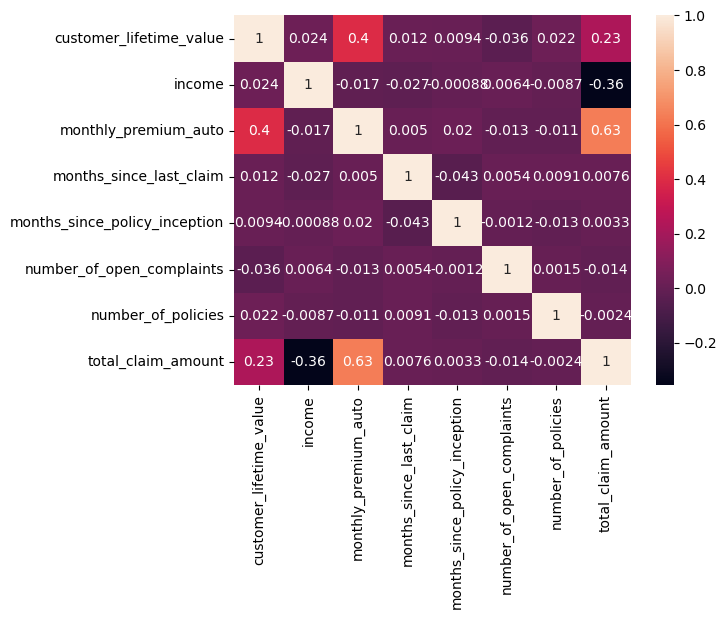

In [4]:
# Defining the maximum correlation threshold and y column
max_correlation = 0.9
ycolumn = 'total_claim_amount'

# Applying the function
mca_df = clean_process(df=mca, max_correlation=max_correlation, ycolumn=ycolumn)


In [8]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(mca_df.drop(['total_claim_amount'], axis=1),
                                                    mca_df['total_claim_amount'], test_size=0.2, random_state = 42)


In [16]:
# Applying linear regression model

lm = linear_model.LinearRegression()
model = lm.fit(X_train,Y_train)
model.score(X_train,Y_train) 


predictions = lm.predict(X_test) 
mse= mean_squared_error(Y_test,predictions)
mae= mean_absolute_error(Y_test,predictions)


In [19]:
mca.total_claim_amount

0        384.811147
1       1131.464935
2        566.472247
3        529.881344
4        138.130879
           ...     
9129     198.234764
9130     379.200000
9131     790.784983
9132     691.200000
9133     369.600000
Name: total_claim_amount, Length: 9134, dtype: float64

In [17]:
print("R2 values is = ", round(r2_score(Y_test, predictions),2))
print("The mean squared error is = ", mse )
print("The mean absolute error is = ", mae )
print("The root mean squared error is = ", np.sqrt(mse) )

R2 values is =  0.76
The mean squared error is =  0.2237648986499639
The mean absolute error is =  0.325649038635207
The root mean squared error is =  0.473037946310826


In [21]:
predictions = lm.predict(X_test) 

mca= pd.DataFrame({'Observed': Y_test, 'Predicted': predictions})
mca


,Observed,Predicted
708,-0.741833,-0.834473
47,0.047179,0.097900
3995,0.058906,0.063843
1513,-0.270055,-0.377197
3686,0.123961,-0.128174
...,...,...
4855,0.798124,0.493164
1880,-1.377420,-1.520020
8472,-1.345797,-0.805664
5967,0.067168,0.309204


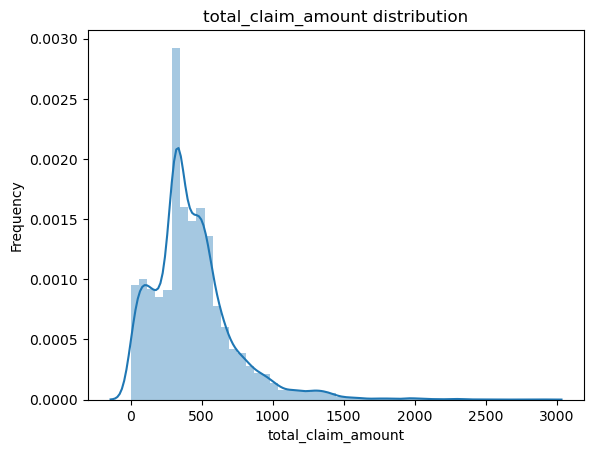

In [20]:
#histogram of total_claim_amount

sns.distplot(mca['total_claim_amount'])
plt.xlabel('total_claim_amount')
plt.ylabel('Frequency')
plt.title('total_claim_amount distribution')
plt.show()